<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-06-tree-based-models-bagging-grf-linear-model-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.6 Linear Model Forest

A **Linear Model Forest** is a machine learning approach that combines the flexibility of random forests with the interpretability of linear models. It is designed to estimate `heterogeneous effects` or `conditional relationships` in data by fitting local linear models within the leaves of a random forest structure. While not a standard term in the `{grf}` package (which focuses on generalized random forests like `causal_forest` or `probability_forest`), the concept is closely related to methods like **Causal Forests with Linear Models** or **Local Linear Forest** extensions, where linear models are used to estimate effects or outcomes at the leaf level. Below, I’ll explain the concept, how it works, and its relevance, keeping it concise and clear.


## Overview

Linear Model Forest estimates conditional relationships (e.g., $E[Y|X]$ or treatment effects $E[Y(1) - Y(0)|X]$) by combining the non-parametric partitioning of random forests with linear models applied locally within subgroups (leaves).  Instead of averaging outcomes in each leaf (as in standard random forests), it fits a `linear model` in each leaf to capture relationships between covariates $X$, outcomes $Y$, or treatments $W$.



### Key Features

- `Heterogeneity`: Captures how relationships or effects vary across subgroups defined by $X$.

- `Interpretability`: Local linear models provide coefficients, making it easier to understand covariate effects within leaves compared to black-box random forests.

- `Flexibility`: Combines non-parametric partitioning (random forest) with parametric modeling (linear models).

- `Robustness`: Ensemble averaging reduces variance and overfitting.

- `Applications`: Ideal for causal inference (e.g., personalized medicine) or regression tasks where linear relationships hold locally but not globally.


### How It Work

A Linear Model Forest modifies the random forest framework as follows:

1. Data Setup

   - Input: Covariates $X$ (e.g., age, sex), outcome $Y$ (e.g., house price), and optionally a treatment  $W$ (covariates).
   - Data is typically a matrix of features $X$, a vector $Y$, and (if causal) a treatment indicator $W$.

2. Tree Construction

   - Like a random forest, it builds multiple decision trees (e.g., 1000) using bootstrap sampling and random feature selection.
   - Each tree partitions the covariate space $X$ into regions (leaves) based on splits that optimize a criterion (e.g., variance reduction or effect heterogeneity).

3. Local Linear Models

   - In each leaf, instead of computing a simple average (as in standard random forests), a `linear model` is fitted using the observations in that leaf.
   - For example:
   
     - `Regression`: $Y \sim \beta_0 + \beta_1 X_1 + \beta_2 X_2$ to predict $E[Y|X]$.
     
     - `Causal`: Estimate treatment effects $\tau(X) = E[Y(1) - Y(0)|X]$ using a linear model of $Y$ on $W$ and $X$.
  
   - The linear model leverages local data to capture linear relationships within the leaf’s subgroup.

4. Aggregation

   - For a given input $X$, each tree assigns $X$ to a leaf, and the local linear model in that leaf provides a prediction (e.g., outcome or treatment effect).
   
   - The forest averages predictions across all trees to produce a final estimate, ensuring robustness and reducing overfitting.

5. Output

   - C`onditional predictions` (e.g., $E[Y|X]$) or heterogeneous treatment effects (e.g., $\tau(X)$).
   
   - Optionally, `local linear coefficients` for interpretability (e.g., how covariates influence outcomes in specific subgroups).

### Differences from Other Forests

- `Vs. Standard Random Forest`: Uses simple averages in leaves, not linear models, and is less interpretable for local relationships.

- `Vs. Causal Forest`: Estimates treatment effects non-parametrically, while a Linear Model Forest uses linear models for effects within leaves, potentially improving precision if linear assumptions hold locally.

- `Vs. Probability Forest`: Focuses on class probabilities for categorical outcomes, not continuous outcomes or treatment effects with linear modeling.



### Limitations

- `Linear Assumption`: Assumes linear relationships within leaves, which may not hold for complex data.

- `Computational Cost`: Fitting linear models in each leaf is more intensive than standard random forest averaging.

- `Implementation`: Not natively supported in `{grf}`; requires custom extensions or alternative packages.

- `Data Requirements`: Needs sufficient data in each leaf to fit reliable linear models.

### Use Cases

  - Estimating heterogeneous treatment effects (e.g., how a drug’s effect varies by patient characteristics).
  - Modeling conditional means with linear relationships within subgroups.
  - Improving interpretability of random forest predictions with local linear coefficients.

## Linear Forest

This tutorial demonstrates how to implement an Instrumental Forest using the `{grf}` package in Python through {rpy2} to estimate the heterogeneous treatment effects (e.g., how house prices vary with different covariates) using a Linear Model Forest. We’ll cover data preparation, model fitting, prediction, and visualization of the estimated effects.




### Setup Python Envrionmewnt

In [ ]:
# Install required Python packages
#%pip install rpy2 pandas numpy matplotlib seaborn scipy # Already executed in previous cells

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr, isinstalled
from scipy import stats

In [ ]:
# Activate automatic conversion between pandas/numpy and R objects
pandas2ri.activate()
numpy2ri.activate()

In [ ]:
%load_ext rpy2.ipython

r = ro.r
r['install.packages']("grf", repos='http://cran.us.r-project.org')
r.library("grf")
r.library("survival")
r.library("ggplot2")

In [ ]:
# Custom IKbandwidth function for RDD (approximate implementation if rdd R package fails)
def IKbandwidth(Z, Y, cutoff, kernel="gaussian"):
    """
    Compute the Imbens-Kalyanaraman optimal bandwidth for RDD.

    Parameters:
    Z : array-like, running variable
    Y : array-like, outcome variable
    cutoff : float, RDD cutoff point
    kernel : str, kernel type for density estimation (default: "gaussian")

    Returns:
    float, optimal bandwidth h
    """
    # If rdd R package is available, use its IKbandwidth function
    if rdd_package is not None:
        try:
            print("Using rdd R package for IK bandwidth calculation.")
            # Ensure Z, Y are R vectors and cutoff is R numeric
            Z_r = ro.FloatVector(Z)
            Y_r = ro.FloatVector(Y)
            cutoff_r = ro.FloatVector([cutoff])
            # Call R's IKbandwidth function
            bandwidth_r = rdd_package.IKbandwidth(Z_r, Y_r, cutoff_r)[0]
            return bandwidth_r
        except Exception as e:
            print(f"Error calling rdd R package IKbandwidth: {str(e)}")
            print("Falling back to approximation.")

    # Fallback approximation if rdd R package is not available or fails
    print("Using fallback approximation for IK bandwidth calculation.")
    Z = np.array(Z)
    Y = np.array(Y)
    n = len(Z)

    # Step 1: Split data at cutoff
    Z_left = Z[Z < cutoff]
    Y_left = Y[Z < cutoff]
    Z_right = Z[Z >= cutoff]
    Y_right = Y[Z >= cutoff]
    n_left = len(Z_left)
    n_right = len(Z_right)

    # Avoid errors with insufficient data on one side
    if n_left < 2 or n_right < 2:
         print("Warning: Insufficient data points on one side of the cutoff for a robust bandwidth calculation. Using a simple fallback.")
         return 1.06 * np.std(Z) * n ** (-1/5) # Silverman's rule as simple fallback


    # Step 2: Estimate initial bandwidth (Silverman's rule as a starting point)
    h1 = 1.06 * np.std(Z) * n ** (-1/5)

    # Step 3: Estimate variance of Y (pooled variance)
    sigma2_left = np.var(Y_left, ddof=1) if n_left > 1 else 0
    sigma2_right = np.var(Y_right, ddof=1) if n_right > 1 else 0
    # Use weighted average if sample sizes are different, handle cases where one side is too small
    total_n = n_left + n_right
    if total_n > 0:
      sigma2 = (sigma2_left * n_left + sigma2_right * n_right) / total_n
    else:
      sigma2 = 1 # Fallback to 1 if no data

    if sigma2 <= 0: # Ensure sigma2 is positive for the formula
        sigma2 = np.var(Y, ddof=1) if n > 1 else 1 # Fallback to overall variance or 1

    # Step 4: Estimate density of Z at cutoff using Gaussian kernel
    # Ensure there are enough points to estimate density
    if n < 10:
         print("Warning: Insufficient total data points for KDE density estimation. Using a simple fallback density.")
         f_c = 1.0 / (np.max(Z) - np.min(Z) + 1e-6) # Approximate density over range
    else:
        try:
            # Need at least 2 data points for KDE
            if len(Z) < 2:
                 f_c = 1e-6
            else:
                 kde = stats.gaussian_kde(Z)
                 f_c = kde(cutoff)[0]
                 if f_c <= 0:
                     f_c = 1e-6  # Avoid division by zero
        except Exception as kde_error:
             print(f"Warning: KDE density estimation failed ({kde_error}). Using a simple fallback density.")
             f_c = 1.0 / (np.max(Z) - np.min(Z) + 1e-6) # Approximate density over range


    # Step 5: Estimate second derivative m''(x) using local quadratic regression
    # This is a simplified approximation. The R implementation is more robust.
    # For a quick Python fallback, we can use polynomial fitting around the cutoff.
    def local_poly_regression(X, Y, x0, degree, h):
        # Simple unweighted polynomial fit within a window h around x0
        subset_indices = np.abs(X - x0) <= h
        X_subset = X[subset_indices]
        Y_subset = Y[subset_indices]

        if len(X_subset) < degree + 1:
            return 0.0 # Not enough data for the polynomial degree

        try:
            # Fit a polynomial of specified degree
            coeffs = np.polyfit(X_subset - x0, Y_subset, degree)
            if degree >= 2:
                # For degree 2 (quadratic), the second derivative is 2 * coefficient of (x-x0)^2
                return 2 * coeffs[degree - 2]
            else:
                 return 0.0 # Second derivative is 0 for degree < 2
        except Exception as poly_error:
            print(f"Warning: Local polynomial regression failed ({poly_error}). Returning 0 for m''.")
            return 0.0 # Fallback if fitting fails

    # Use a window size for the local quadratic fit, maybe 2*h1
    local_window = 2 * h1
    m2_left = local_poly_regression(Z_left, Y_left, cutoff, degree=2, h=local_window)
    m2_right = local_poly_regression(Z_right, Y_right, cutoff, degree=2, h=local_window)
    m2 = (m2_left + m2_right) / 2
    if abs(m2) < 1e-6: # Use absolute value and a small tolerance
        m2 = 1e-6 if m2 >= 0 else -1e-6 # Avoid division by zero, keep sign

    # Step 6: Compute IK constant C_k for Gaussian kernel (approximation)
    # C_k = 3.4375 # Approximate constant for Gaussian kernel (from IK paper) - specific to Gaussian
    # For triangular kernel (often used in RDD): C_k is different.
    # Let's assume the user wants the optimal bandwidth for local linear regression with triangular kernel,
    # as often used in RDD. The constant for triangular kernel is often cited around 2.346.
    C_k = 2.346 # Constant for Triangular kernel

    # Step 7: Compute optimal bandwidth
    # Formula: h_opt = C * (sigma^2 / (n * f(c) * (m''(c))^2))^(1/5)
    # Ensure denominator is not zero or too small
    denominator = n * f_c * m2**2
    if denominator < 1e-12:
        print("Warning: Denominator for bandwidth calculation is too small. Using a simple fallback.")
        h_opt = 1.06 * np.std(Z) * n ** (-1/5) # Silverman's rule as fallback
    else:
        h_opt = C_k * (sigma2 / denominator) ** (1/5)

    return max(h_opt, 1e-6)  # Ensure positive and reasonable bandwidth

### Load Boston Housing Dataset

We use the Boston Housing dataset to demonstrate the implementation of a Regression Discontinuity Design (RDD) using the `{grf}` package. The dataset contains information about housing values in suburbs of Boston, including various features like crime rate, number of rooms, and more.


In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
boston_df = pd.DataFrame(data, columns=feature_names)
boston_df['medv'] = target
boston_df = boston_df.dropna() # Remove missing values


### Prepare Data for RDD Analysis

RDD (Regression Discontinuity Design) is a quasi-experimental design used to estimate causal effects when treatment assignment is determined by a cutoff on a continuous variable. In this example, we will use the Boston Housing dataset to demonstrate how to implement RDD using the {grf}


In [ ]:
# Prepare Data for RDD Analysis (using boston_df)
try:
    Z = boston_df['NOX'].values  # Running variable (nitric oxides concentration)
    cutoff = np.median(Z)  # Cutoff at median NOX
    W = (Z >= cutoff).astype(int)  # Treatment: 1 if NOX >= cutoff, else 0
    Y = boston_df['medv'].values  # Outcome: median value of owner-occupied homes
    X_covariates = boston_df.drop(['medv', 'NOX'], axis=1)  # Covariates excluding outcome & running variable
    X_matrix_covariates = np.array(X_covariates)  # Convert to numpy array for R compatibility (if needed)

except KeyError as e:
    print(f"Error accessing columns in boston_df: {str(e)}")
    print("Available columns:", boston_df.columns.tolist())
    raise

### Imbens-Kalyanaraman (IK) Optimal Bandwidth and Kernel Weights

To implement Regression discontinuity designs (RDD) using the `grf` package, we first need to compute the bandwidth for the running variable and then apply kernel weights to subset the data. First we will use our coustom `IKbandwith()` function to calculate the `Imbens-Kalyanaraman optimal bandwidth` for local linear regression in RDD.

In [ ]:
# Compute Imbens-Kalyanaraman (IK) Optimal Bandwidth using our Python function (or R if available)
try:
    bandwidth_py = IKbandwidth(Z, Y, cutoff)
    print(f"Calculated IK Bandwidth: {bandwidth_py}")
except Exception as e:
    print(f"Error computing IK bandwidth: {str(e)}")
    # Fallback to a simple bandwidth if calculation fails
    n = len(Z)
    bandwidth_py = 1.06 * np.std(Z) * n ** (-1/5)
    print(f"Fallback to Silverman's rule bandwidth: {bandwidth_py}")


Using fallback approximation for IK bandwidth calculation.
Calculated IK Bandwidth: 0.0771011422807454


Then we will calculate the kernel weights using the using our function `kernelwts_py()` function. This function will calculate the appropriate kernel weights for a vector. This is useful when, for instance, one wishes to perform local regression.

In [ ]:
# Compute triangular kernel weights using our Python function
def kernelwts_py(Z, cutoff, bandwidth, kernel="triangular"):
    h = bandwidth
    u = (Z - cutoff) / h
    if kernel == "triangular":
        weights = np.maximum(0, 1 - np.abs(u)) # Corrected line
    else:
        raise ValueError("Only triangular kernel is implemented")
    return weights

# Calculate sample weights and subset the data within the bandwidth
sample_weights_py = kernelwts_py(Z, cutoff, bandwidth_py)
subset_py = sample_weights_py > 0

print(f"\nNumber of samples within bandwidth: {sum(subset_py)}")



Number of samples within bandwidth: 226


### Fit Local Linear Forest Targeting RDD Effect

We will use the `lm_forest()` function from the `{grf}` package to fit a local linear forest model that targets the RDD effect. The `gradient.weights` argument is set to `c(1, 0)` to indicate that we are interested in estimating the treatment effect (tau) at each point in the running variable.

In [ ]:
# Fit Local Linear Forest Targeting RDD Effect using grf
if grf is None:
    raise Exception("grf package is required but not installed.")
X_subset = X_matrix_covariates[subset_py, :]
Y_subset = Y[subset_py]
W_subset = W[subset_py]
Z_subset = Z[subset_py]
sample_weights_subset = sample_weights_py[subset_py]

# Convert data to R objects
X_r = ro.r.matrix(X_subset, nrow=X_subset.shape[0], ncol=X_subset.shape[1])
Y_r = ro.FloatVector(Y_subset)
WZ_r = ro.r.matrix(np.column_stack([W_subset, Z_subset]), nrow=sum(subset_py), ncol=2)
sample_weights_r = ro.FloatVector(sample_weights_subset)
gradient_weights_r = ro.FloatVector([1, 0])

# Fit lm_forest
try:
    lmf = grf.lm_forest(X_r, Y_r, WZ_r, sample_weights=sample_weights_r, gradient_weights=gradient_weights_r)
    print(lmf)
except Exception as e:
    print(f"Error fitting lm_forest: {str(e)}")
    raise

GRF forest object of type lm_forest 
Number of trees: 2000 
Number of training samples: 226 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10    11    12 
0.121 0.062 0.148 0.002 0.087 0.050 0.093 0.012 0.082 0.222 0.040 0.082 



### Extract RDD Estimates (tau at each x)

In [ ]:
# Extract RDD Estimates (tau at each x)
tau_hat = ro.r.predict(lmf).rx2('predictions')[:, 0]
# Display first few RDD treatment effect estimates
print("First few RDD treatment effect estimates (tau.hat):")
print(tau_hat[:5])

First few RDD treatment effect estimates (tau.hat):
[[10.4095273 ]
 [ 3.10756689]
 [-0.10688567]
 [ 1.96822885]
 [ 2.71713393]]



Summary of tau.hat:
count    226.000000
mean      -1.436747
std        2.220702
min       -7.107399
25%       -2.710928
50%       -1.427106
75%       -0.030738
max       10.409527
dtype: float64


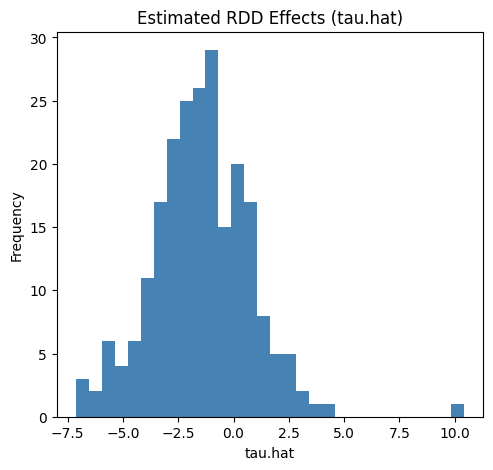

In [ ]:
# Summary and diagnostics
print("\nSummary of tau.hat:")
# Flatten tau_hat to ensure it's 1-dimensional for pd.Series
print(pd.Series(tau_hat.flatten()).describe())

# Plot histogram of estimated RDD effects
plt.figure(figsize=(5.5, 5))
plt.hist(tau_hat.flatten(), bins=30, color='steelblue') # Also flatten for histogram
plt.title("Estimated RDD Effects (tau.hat)")
plt.xlabel("tau.hat")
plt.ylabel("Frequency")
plt.show()

### Prediction and Visualization

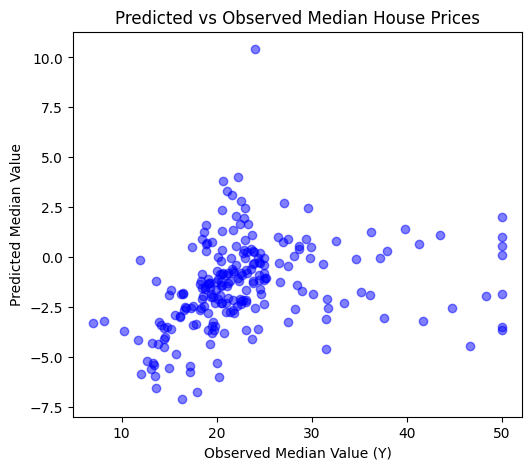

In [ ]:
# Prediction and Visualization
Y_pred = ro.r.predict(lmf).rx2('predictions')[:, 0]
Y_obs = Y_subset

plt.figure(figsize=(5.8, 5))
plt.scatter(Y_obs, Y_pred, c='blue', alpha=0.5)
plt.xlabel("Observed Median Value (Y)")
plt.ylabel("Predicted Median Value")
plt.title("Predicted vs Observed Median House Prices")
plt.show()

### Variable Importance

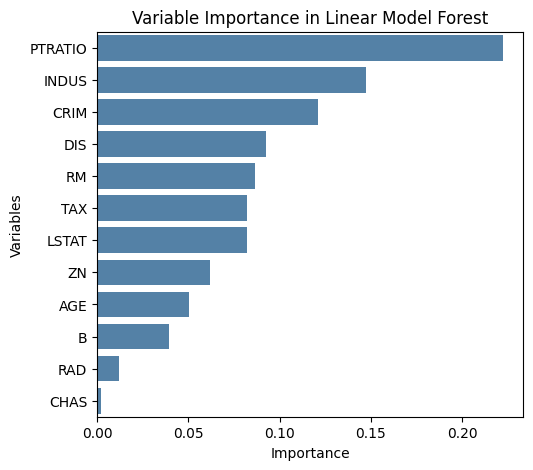

In [ ]:
# Variable Importance
importance = np.array(grf.variable_importance(lmf))
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': importance.flatten()
}).sort_values('Importance', ascending=False)

# Plot variable importance
plt.figure(figsize=(5.5, 5))
sns.barplot(x='Importance', y='Variable', data=importance_df, color='steelblue')
plt.title("Variable Importance in Linear Model Forest")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.show()

## Summary and Conclusion

The notebook  introduces the concept of a Linear Model Forest, explaining how it combines random forest partitioning with local linear models within the leaves to estimate heterogeneous effects. It highlights the key features, how it works, and its differences from other forest types. The practical implementation focuses on using the `grf` R package via `rpy2` in Python to perform a Regression Discontinuity Design (RDD) analysis on the Boston Housing dataset. It calculates the optimal bandwidth, applies kernel weights, fits an `lm_forest` targeting the RDD effect, and visualizes the estimated treatment effects and variable importance.




## References

1. Athey, Susan, Julie Tibshirani, and Stefan Wager. "Generalized Random Forests". Annals of Statistics, 47(2), 2019.

2. Zeileis, Achim, Torsten Hothorn, and Kurt Hornik. "Model-based Recursive Partitioning." Journal of Computational and Graphical Statistics 17(2), 2008.

3. [LM Forest](https://grf-labs.github.io/grf/reference/lm_forest.html#references)

4. [RegressionForest](https://econml.azurewebsites.net/_autosummary/econml.grf.RegressionForest.html)